# Pose detection + position estimation

Generar N frames sintéticos + "labels":
- Procesar los N frames sintéticos con un modelo de pose detection ya entrenado -> keypoints 
- Entrar un modelo de aprendizaje supervisado para predecir la posición de un jugador sobre el campo

### Imports

In [20]:
%load_ext autoreload
%autoreload 2
from utils.extractFrames import extractFrames
from utils.inferenceMMpose import inferenceMMpose
from utils.inferencePP import inferenciaPosicion, dibujar_prediccion, inferenciaVideo, inferenciaVideoMultiploFrames
from utils.makeVideo import makeVideo
from utils.datos import cargar_datos_blender, tratamiento_datos, cambiar_input_frames
from utils.neuralNetwork import NeuralNetwork
from utils.neuralNetworkMF import NeuralNetworkMF
from utils.SimpleDataset import SimpleDataset
from utils.training import training
from torch import nn 
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import DataLoader
from PIL import Image
import os
import cv2
import torch
import numpy as np
import torch.optim as optim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Parte 1
Procesar los N (14660) frames sintéticos de Blender con un modelo de pose detection ya entrenado 

In [6]:
%run demo/topdown_demo_with_mmdet \
    demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py \
    https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth \
    configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py \
    https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth \
    --input inputs/1630-16300.mp4 --save-predictions \
    --output-root outputs/Blender/ 

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14660/14660, 2.0 task/s, elapsed: 7379s, ETA:     0s

C:\Users\crv\miniconda3\envs\openmmlab\lib\site-packages\json_tricks\encoders.py:394: UserWarning: json-tricks: numpy scalar serialization is experimental and may work differently in future versions
  warnings.warn('json-tricks: numpy scalar serialization is experimental and may work differently in future versions')


predictions have been saved at outputs/Blender//results_1630-16300.json


### Parte 2
Entrenar un modelo de aprendizaje supervisado (Fully neural network) para predecir la posición (x, y) del jugador sobre la pista a partir de los keypoints calculados anteriormente

 - Tratamiento de datos de entrada (1 solo frame)

In [69]:
path_keypoints = '/Users/jiabowang/Desktop/TFG/data/Blender/results_1630-16300.json'
path_truth = '/Users/jiabowang/Desktop/TFG/data/Blender/labels-1630-16300.csv'

X, y, hip = cargar_datos_blender(path_keypoints, path_truth)
X, y = tratamiento_datos(X, y, hip)
# convertirlos en tensores
X = torch.tensor(X, dtype=torch.float32)
X = torch.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
y = torch.tensor(y, dtype=torch.float32)

print(X.shape)
print(y.shape)

torch.Size([14638, 34])
torch.Size([14638, 2])


 - Construcción del modelo

In [70]:
model = NeuralNetwork()

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('numero de parametros a entrenar', params)
print(model)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Partición del data en training y test (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

numero de parametros a entrenar 594
NeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=34, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)


 - Entrenamiento de los datos

FOLD 0
--------------------------------
Epoch 1 		 Training Loss: 8953.512151575485 		 Validation Loss: 6779.292485834478
Epoch 2 		 Training Loss: 4346.006716234202 		 Validation Loss: 2068.506550212483
Epoch 3 		 Training Loss: 999.5065414978196 		 Validation Loss: 403.553469144381
Epoch 4 		 Training Loss: 325.6400576139751 		 Validation Loss: 264.9356219113528
Epoch 5 		 Training Loss: 257.75426311968437 		 Validation Loss: 225.87935596507984
Epoch 6 		 Training Loss: 222.05163443187598 		 Validation Loss: 195.5698020012824
Epoch 7 		 Training Loss: 194.54300636862123 		 Validation Loss: 172.12918920831365
Epoch 8 		 Training Loss: 173.86233544811978 		 Validation Loss: 154.44283898322138
Epoch 9 		 Training Loss: 158.80579669984093 		 Validation Loss: 141.7128166785607
Epoch 10 		 Training Loss: 148.30213131468713 		 Validation Loss: 132.74445493928678
Epoch 11 		 Training Loss: 141.14098249313903 		 Validation Loss: 126.46007512689947
Epoch 12 		 Training Loss: 136.28059792980923

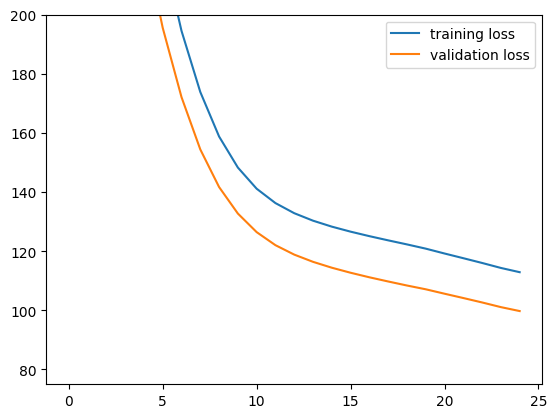

FOLD 1
--------------------------------
Epoch 1 		 Training Loss: 107.45246524757955 		 Validation Loss: 114.45515634725382
Epoch 2 		 Training Loss: 106.26586944706882 		 Validation Loss: 113.38380968701709
Epoch 3 		 Training Loss: 105.26037540594297 		 Validation Loss: 112.48019337916112
Epoch 4 		 Training Loss: 104.40362936638068 		 Validation Loss: 111.69236365517418
Epoch 5 		 Training Loss: 103.67597567275621 		 Validation Loss: 111.01500823471572
Epoch 6 		 Training Loss: 103.04139560477556 		 Validation Loss: 110.41021879426725
Epoch 7 		 Training Loss: 102.49213955739198 		 Validation Loss: 109.87068897289234
Epoch 8 		 Training Loss: 102.00838214736896 		 Validation Loss: 109.40095985328759
Epoch 9 		 Training Loss: 101.57178500484562 		 Validation Loss: 108.97124242258596
Epoch 10 		 Training Loss: 101.18818502346895 		 Validation Loss: 108.58955680931007
Epoch 11 		 Training Loss: 100.84437126730288 		 Validation Loss: 108.23909344515958
Epoch 12 		 Training Loss: 100.538

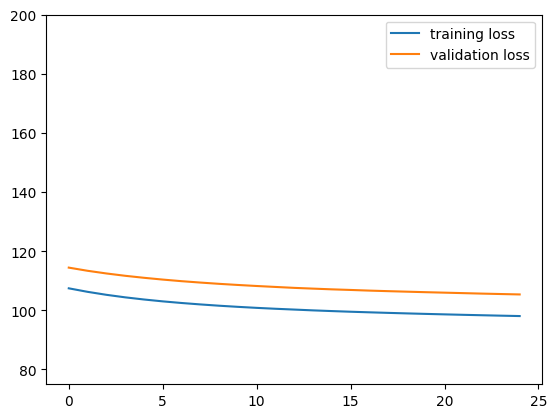

FOLD 2
--------------------------------
Epoch 1 		 Training Loss: 97.83833101119362 		 Validation Loss: 104.51815085358672
Epoch 2 		 Training Loss: 97.65277911157159 		 Validation Loss: 104.49884194594163
Epoch 3 		 Training Loss: 97.48807317464305 		 Validation Loss: 104.44670201395894
Epoch 4 		 Training Loss: 97.33537117596148 		 Validation Loss: 104.39044734409877
Epoch 5 		 Training Loss: 97.1915128237653 		 Validation Loss: 104.31607774587778
Epoch 6 		 Training Loss: 97.05022007210432 		 Validation Loss: 104.24918241815253
Epoch 7 		 Training Loss: 96.91733609672399 		 Validation Loss: 104.17316044817915
Epoch 8 		 Training Loss: 96.79023194247006 		 Validation Loss: 104.0895455119374
Epoch 9 		 Training Loss: 96.66300272743457 		 Validation Loss: 103.9954933334183
Epoch 10 		 Training Loss: 96.5396920994048 		 Validation Loss: 103.90071663489708
Epoch 11 		 Training Loss: 96.41985269266482 		 Validation Loss: 103.81297113607218
Epoch 12 		 Training Loss: 96.30323867058159 		 V

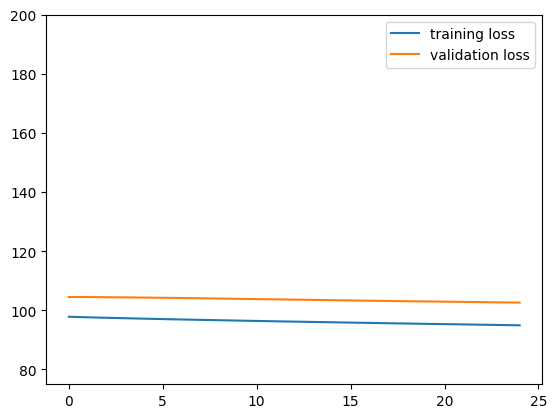

FOLD 3
--------------------------------
Epoch 1 		 Training Loss: 96.56797038154919 		 Validation Loss: 97.70303411798163
Epoch 2 		 Training Loss: 96.40640811973002 		 Validation Loss: 97.70151108961839
Epoch 3 		 Training Loss: 96.27558371102711 		 Validation Loss: 97.67869337312467
Epoch 4 		 Training Loss: 96.15460124240357 		 Validation Loss: 97.63064264989161
Epoch 5 		 Training Loss: 96.04053039762123 		 Validation Loss: 97.56557028634208
Epoch 6 		 Training Loss: 95.92146263756581 		 Validation Loss: 97.49274356548602
Epoch 7 		 Training Loss: 95.80903855849502 		 Validation Loss: 97.42294399554913
Epoch 8 		 Training Loss: 95.7015797781482 		 Validation Loss: 97.33537598494645
Epoch 9 		 Training Loss: 95.59071777005605 		 Validation Loss: 97.25075589693509
Epoch 10 		 Training Loss: 95.48799676974394 		 Validation Loss: 97.15917105203147
Epoch 11 		 Training Loss: 95.3854839980107 		 Validation Loss: 97.10321082649651
Epoch 12 		 Training Loss: 95.28047306980122 		 Validation

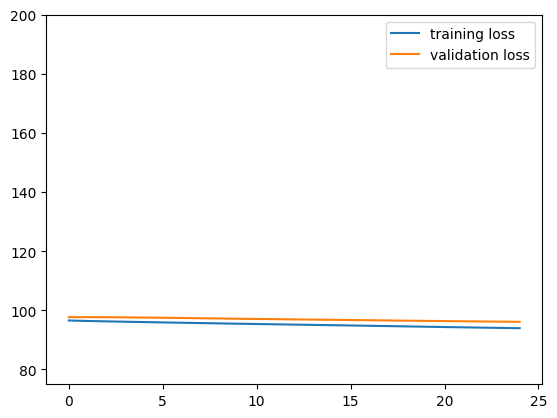

FOLD 4
--------------------------------
Epoch 1 		 Training Loss: 95.52220018022278 		 Validation Loss: 89.01797762021914
Epoch 2 		 Training Loss: 95.42362374281949 		 Validation Loss: 88.98433614039159
Epoch 3 		 Training Loss: 95.32637285459735 		 Validation Loss: 88.9362723172366
Epoch 4 		 Training Loss: 95.23581639023038 		 Validation Loss: 88.89098982758574
Epoch 5 		 Training Loss: 95.14811496259102 		 Validation Loss: 88.83040652432284
Epoch 6 		 Training Loss: 95.06061571390676 		 Validation Loss: 88.78284127371651
Epoch 7 		 Training Loss: 94.97530572632343 		 Validation Loss: 88.73428248311137
Epoch 8 		 Training Loss: 94.88972904279291 		 Validation Loss: 88.67822582119113
Epoch 9 		 Training Loss: 94.80556304170814 		 Validation Loss: 88.61089985187238
Epoch 10 		 Training Loss: 94.71765373420187 		 Validation Loss: 88.54595915825813
Epoch 11 		 Training Loss: 94.62968372968426 		 Validation Loss: 88.48148356427203
Epoch 12 		 Training Loss: 94.54064513969949 		 Validatio

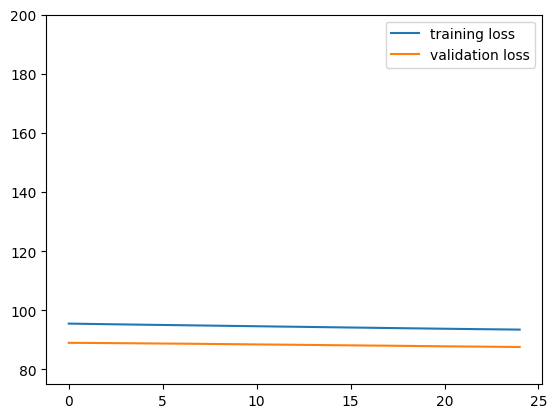

In [71]:
epochs = 25
batch = 26
simple_dataset = SimpleDataset(X_train, y_train)
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_ids, valid_ids) in enumerate(kfold.split(simple_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_loader = DataLoader(simple_dataset, batch_size=batch, sampler=train_ids)
    valid_loader = DataLoader(simple_dataset, batch_size=batch, sampler=valid_ids)

    training(epochs, model, train_loader, valid_loader, optimizer, loss_fn)

#save model
PATH = '/Users/jiabowang/Desktop/TFG/data/Models'
torch.save(model, PATH)
#añadir punto medio del hip

In [81]:
model = torch.load('/Users/jiabowang/Desktop/TFG/data/Models')
target = model(X_test)
# Find the Loss
loss = loss_fn(target,y_test)
print("loss testing con datos no vistos", loss)

loss testing con datos no vistos tensor(91.0269, grad_fn=<MseLossBackward0>)


 - Inferencia con datos reales

/Users/jiabowang/miniconda3/envs/openmmlab/lib/python3.10/site-packages/mmpose/datasets/datasets/utils.py:102: UserWarning: The metainfo config file "configs/_base_/datasets/coco.py" does not exist. A matched config file "/Users/jiabowang/miniconda3/envs/openmmlab/lib/python3.10/site-packages/mmpose/.mim/configs/_base_/datasets/coco.py" will be used instead.
  warnings.warn(


Loads checkpoint by local backend from path: /Users/jiabowang/Desktop/TFG/data/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by local backend from path: /Users/jiabowang/Desktop/TFG/data/hrnet_w32_coco_256x192-c78dce93_20200708.pth
05/26 13:36:58 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


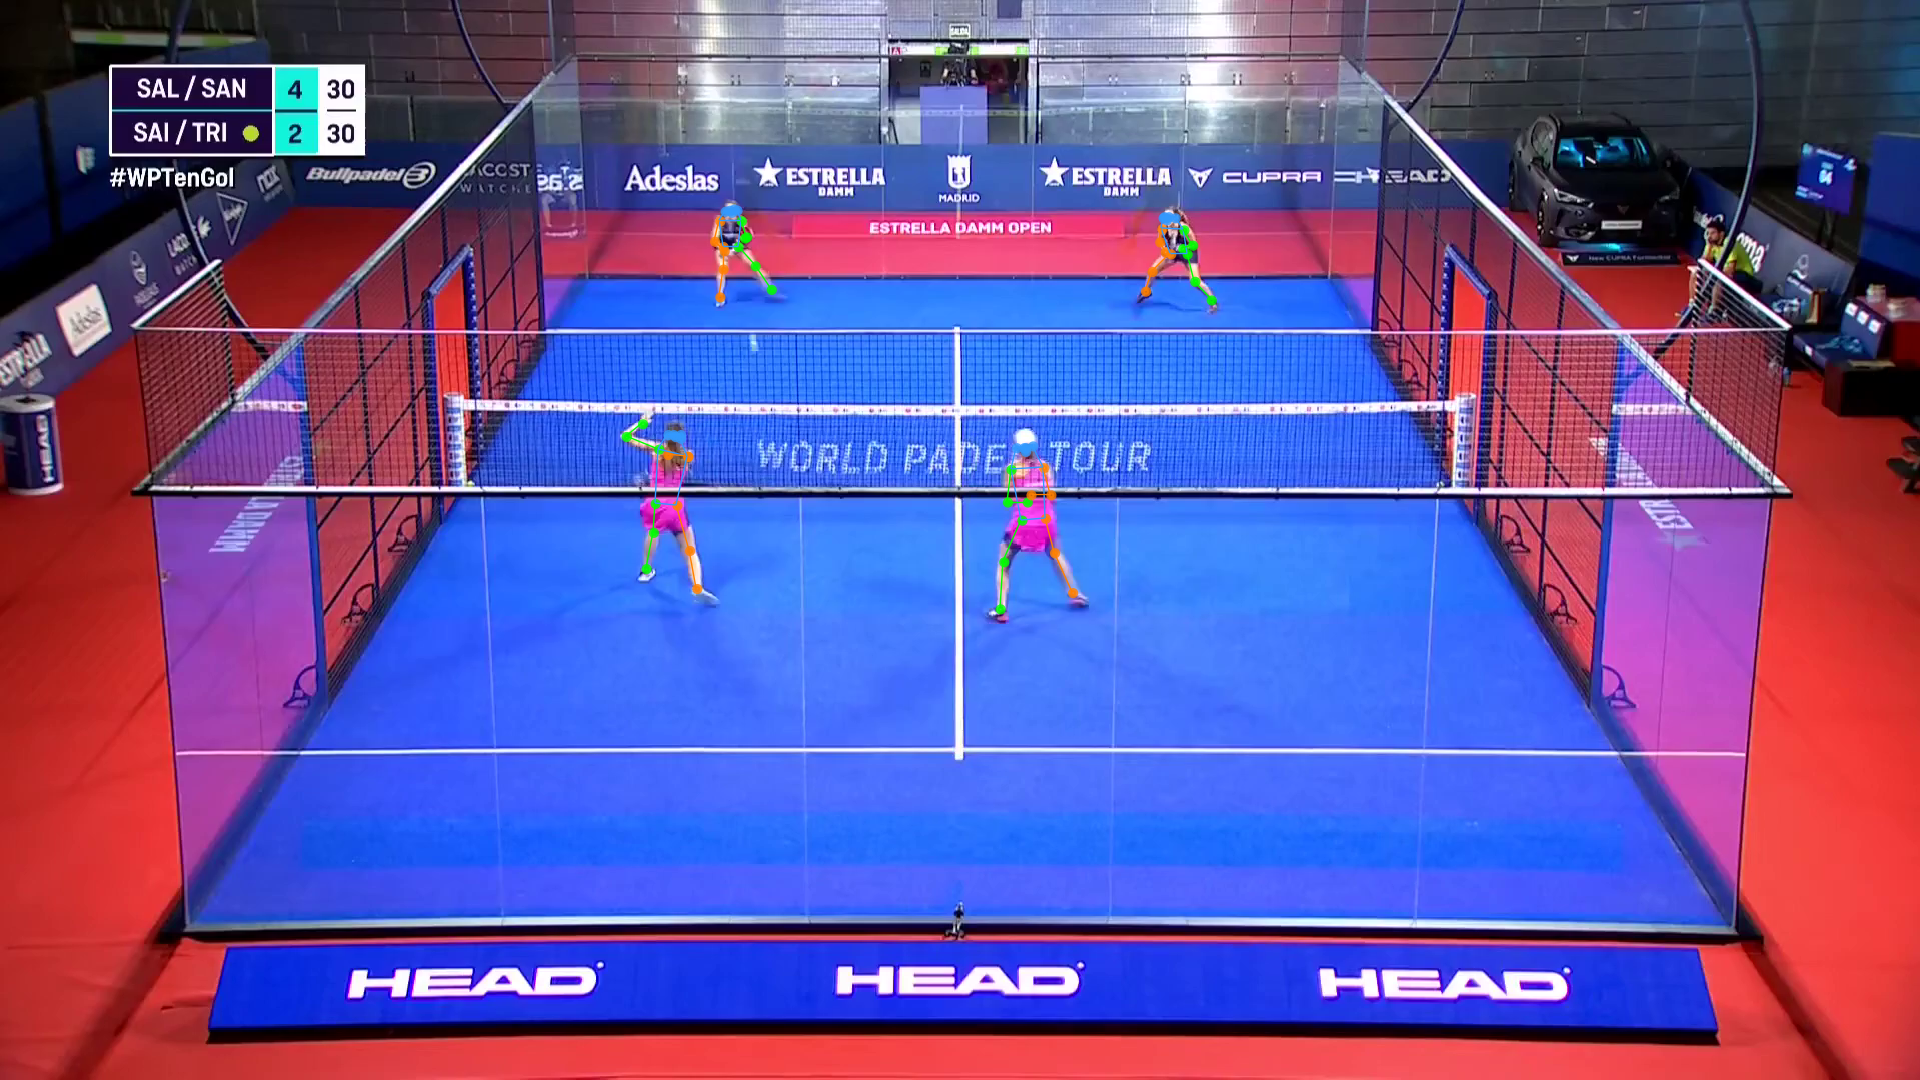

In [86]:
input_path = "/Users/jiabowang/Desktop/TFG/mmpose/outputs/f/frame0.png"
output_path = '/Users/jiabowang/Desktop/TFG/outputs/'

inferenceMMpose(input_path, output_path, False) 

Image.open('/Users/jiabowang/Desktop/TFG/outputs/frame0.png')

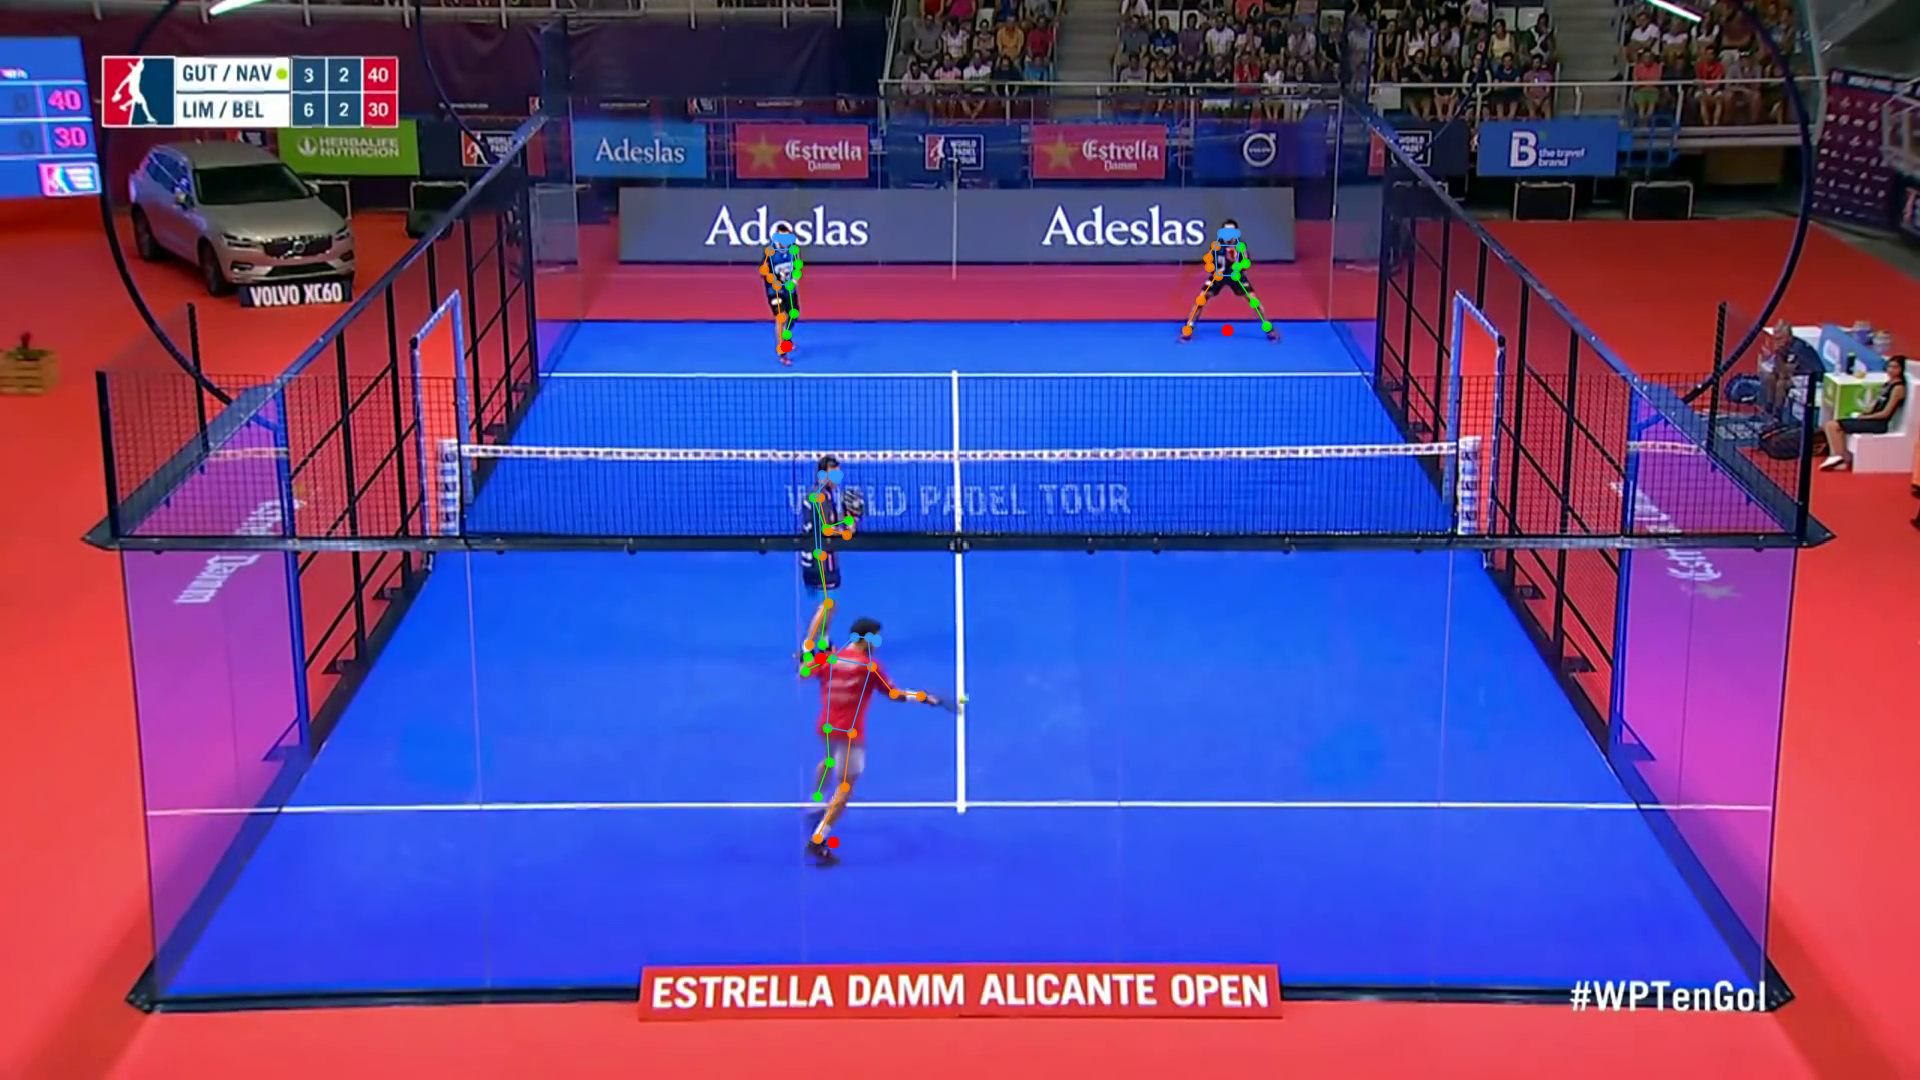

In [108]:
model = torch.load('/Users/jiabowang/Desktop/TFG/data/Models')
keypoints_path = '/Users/jiabowang/Desktop/TFG/outputs/results_Salto.json'
predicciones = inferenciaPosicion(model, keypoints_path)

img_pos = dibujar_prediccion(predicciones, '/Users/jiabowang/Desktop/TFG/outputs/Salto.png')
output_path = '/Users/jiabowang/Desktop/TFG/outputs'
filename = 'Salto_pos.png'
cv2.imwrite(os.path.join(output_path , filename), img_pos)

Image.open(output_path + '/' + filename)

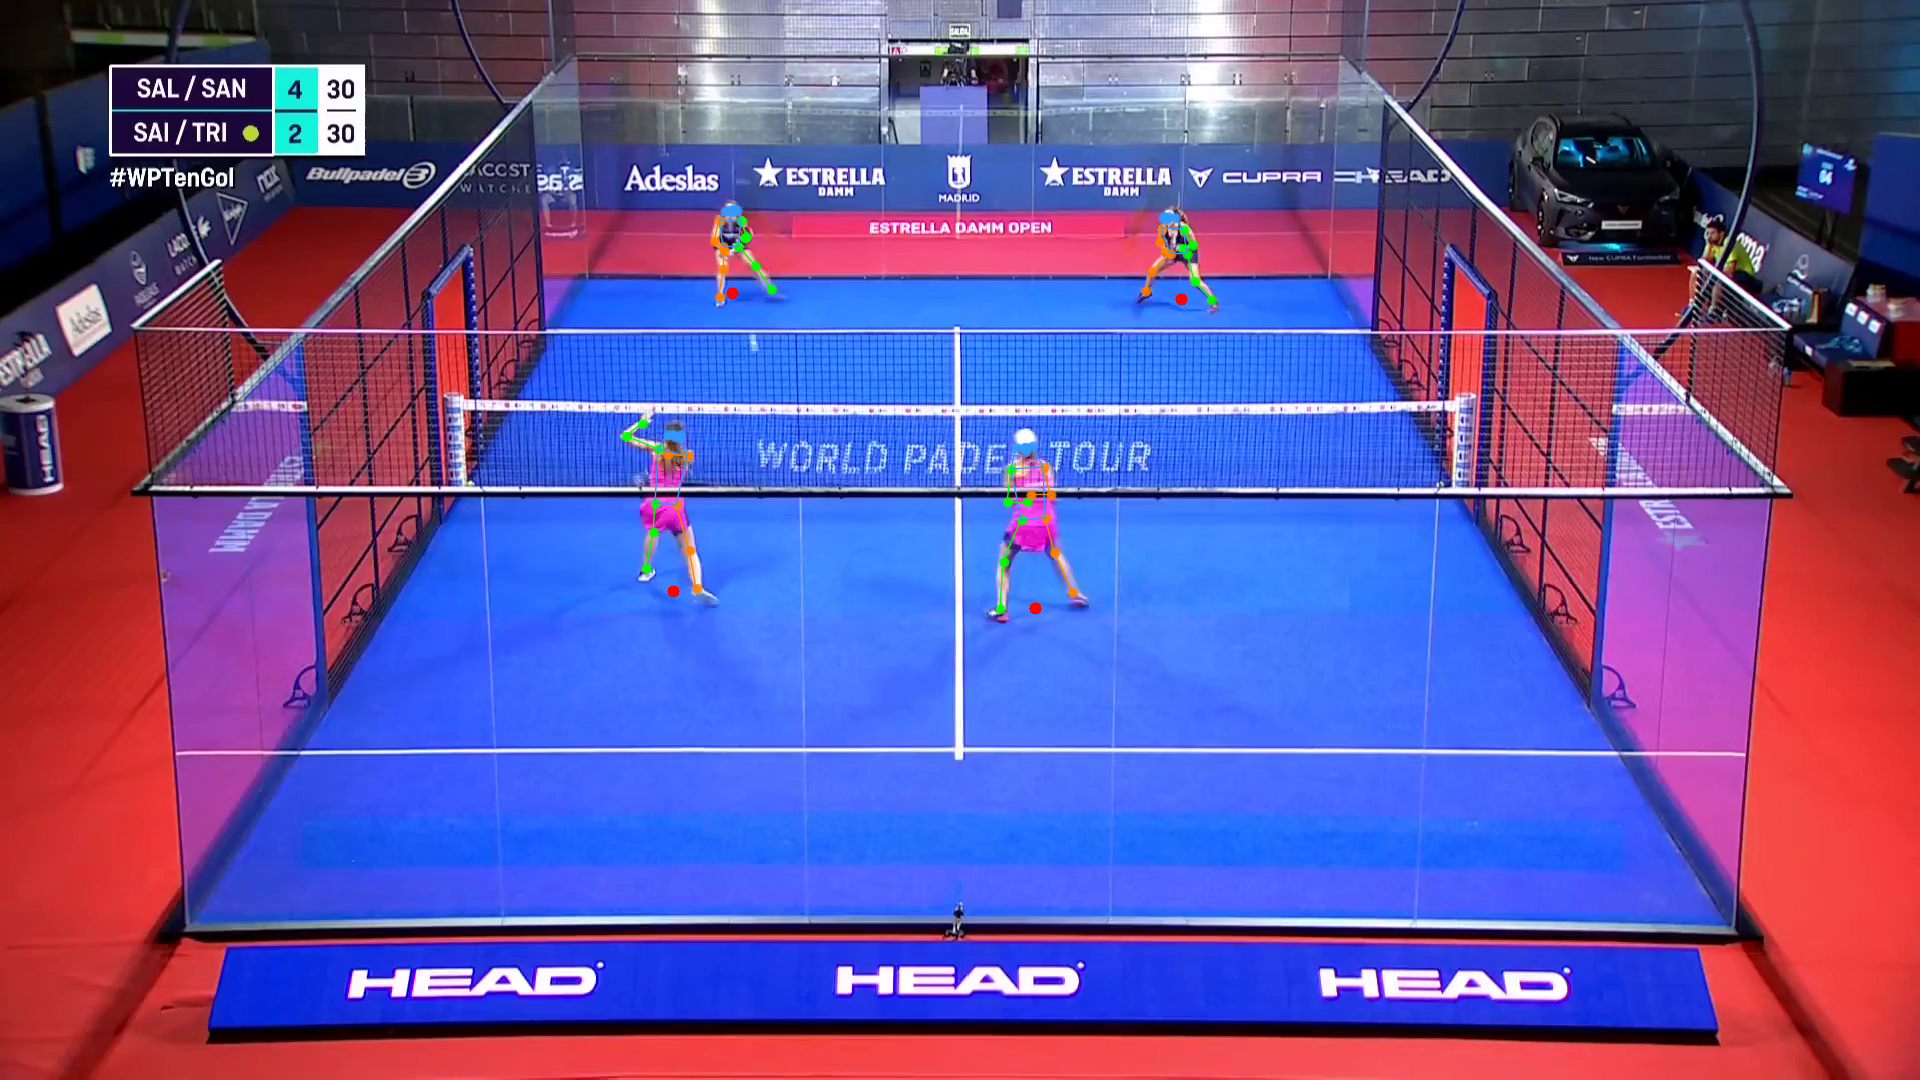

In [109]:
model = torch.load('/Users/jiabowang/Desktop/TFG/data/Models')
keypoints_path = '/Users/jiabowang/Desktop/TFG/outputs/results_frame0.json'
predicciones = inferenciaPosicion(model, keypoints_path)

img_pos = dibujar_prediccion(predicciones, '/Users/jiabowang/Desktop/TFG/outputs/frame0.png')
output_path = '/Users/jiabowang/Desktop/TFG/outputs'
filename = 'frame0_pos.png'
cv2.imwrite(os.path.join(output_path , filename), img_pos)

Image.open(output_path + '/' + filename)

In [115]:
path_keypoints = '/Users/jiabowang/Desktop/TFG/data/Blender/results_1630-16300.json'
path_truth = '/Users/jiabowang/Desktop/TFG/data/Blender/labels-1630-16300.csv'
video_input = "/Users/jiabowang/Desktop/TFG/data/1630-16300.mp4"
video_output = "/Users/jiabowang/Desktop/TFG/outputs/padel1frame.mp4"
path_model = '/Users/jiabowang/Desktop/TFG/data/Models'
inferenciaVideo(path_model, path_keypoints, path_truth, video_input, video_output)

In [120]:
model = torch.load('/Users/jiabowang/Desktop/TFG/data/Models')
for i in range(0,150):
    keypoints_path = '/Users/jiabowang/Desktop/TFG/outputs/video/results_frame' + str(i) + '.json'
    predicciones = inferenciaPosicion(model, keypoints_path)
    
    img_pos = dibujar_prediccion(predicciones, '/Users/jiabowang/Desktop/TFG/outputs/video/frame' + str(i) + '.png')
    output_path = '/Users/jiabowang/Desktop/TFG/outputs/video_pos'
    filename = 'frame' + str(i) + '.png'
    cv2.imwrite(os.path.join(output_path , filename), img_pos)
makeVideo('/Users/jiabowang/Desktop/TFG/outputs/video_pos', '/Users/jiabowang/Desktop/TFG/outputs/test.mp4')

### Tratamiento de datos de entrada (23 frames)

In [16]:
path_keypoints = '/Users/jiabowang/Desktop/TFG/data/Blender/results_1630-16300.json'
path_truth = '/Users/jiabowang/Desktop/TFG/data/Blender/labels-1630-16300.csv'

X_aux, y_aux, hip = cargar_datos_blender(path_keypoints, path_truth)

X_aux, y_aux = tratamiento_datos(X_aux, y_aux, hip)

X, y = cambiar_input_frames(X_aux, y_aux, 23, 6)

# convertirlos en tensores
X = torch.tensor(X, dtype=torch.float32)
print(X.shape)
X = torch.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]*X.shape[3]))
y = torch.tensor(y, dtype=torch.float32)
print(X.shape)
print(y.shape)

torch.Size([14500, 23, 17, 2])
torch.Size([14500, 782])
torch.Size([14500, 2])


In [17]:
model = NeuralNetworkMF()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('numero de parametros a entrenar', params)
print(model)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Partición del data en training y test (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

numero de parametros a entrenar 6282
NeuralNetworkMF(
  (linear): Sequential(
    (0): Linear(in_features=782, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=8, out_features=2, bias=True)
  )
)


FOLD 0
--------------------------------
Epoch 1 		 Training Loss: 3413.7301704652846 		 Validation Loss: 653.1531157797956
Epoch 2 		 Training Loss: 242.52779072587208 		 Validation Loss: 151.7907466482609
Epoch 3 		 Training Loss: 147.40330025457567 		 Validation Loss: 134.01143613774727
Epoch 4 		 Training Loss: 130.34727652354906 		 Validation Loss: 121.26233713677588
Epoch 5 		 Training Loss: 118.04232511212749 		 Validation Loss: 112.11747628069938
Epoch 6 		 Training Loss: 109.19600923599735 		 Validation Loss: 105.70932217861744
Epoch 7 		 Training Loss: 102.87260318058793 		 Validation Loss: 101.16294073551259
Epoch 8 		 Training Loss: 98.2891858828965 		 Validation Loss: 97.99910825364132
Epoch 9 		 Training Loss: 94.8349436893258 		 Validation Loss: 95.55055423493081
Epoch 10 		 Training Loss: 92.08224411420925 		 Validation Loss: 93.53466723827606
Epoch 11 		 Training Loss: 89.75346495515556 		 Validation Loss: 91.93745584690825
Epoch 12 		 Training Loss: 87.69033930378575 	

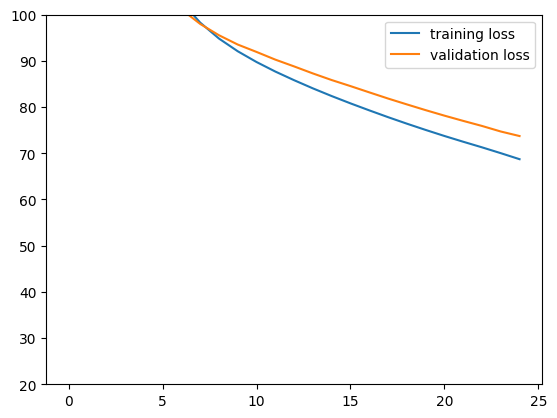

FOLD 1
--------------------------------
Epoch 1 		 Training Loss: 69.38636874127131 		 Validation Loss: 67.6997513466693
Epoch 2 		 Training Loss: 68.07207987385411 		 Validation Loss: 66.55301788005423
Epoch 3 		 Training Loss: 66.78924289826423 		 Validation Loss: 65.37214684993663
Epoch 4 		 Training Loss: 65.5945297569357 		 Validation Loss: 64.4264047500935
Epoch 5 		 Training Loss: 64.51197359638829 		 Validation Loss: 63.43221656312334
Epoch 6 		 Training Loss: 63.39859053909138 		 Validation Loss: 62.50334516484687
Epoch 7 		 Training Loss: 62.171787959273146 		 Validation Loss: 61.518620876555744
Epoch 8 		 Training Loss: 61.038695899389126 		 Validation Loss: 60.593947065637465
Epoch 9 		 Training Loss: 60.088918685913086 		 Validation Loss: 59.73943681919828
Epoch 10 		 Training Loss: 59.137284391669816 		 Validation Loss: 58.91373021551903
Epoch 11 		 Training Loss: 58.26499877437468 		 Validation Loss: 58.152551691582865
Epoch 12 		 Training Loss: 57.440661450868014 		 Val

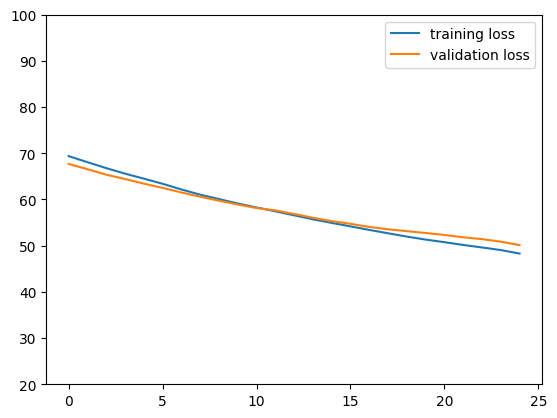

FOLD 2
--------------------------------
Epoch 1 		 Training Loss: 48.277019716078236 		 Validation Loss: 46.38151530002026
Epoch 2 		 Training Loss: 47.28719545179798 		 Validation Loss: 46.10103542246717
Epoch 3 		 Training Loss: 46.45324968522595 		 Validation Loss: 45.85536729528549
Epoch 4 		 Training Loss: 45.660373656980454 		 Validation Loss: 45.68394182083455
Epoch 5 		 Training Loss: 44.863362794281336 		 Validation Loss: 45.130139290018285
Epoch 6 		 Training Loss: 44.079147277339814 		 Validation Loss: 44.848830689775184
Epoch 7 		 Training Loss: 43.33303023922828 		 Validation Loss: 44.38877641393783
Epoch 8 		 Training Loss: 42.60083525667908 		 Validation Loss: 44.007442068546375
Epoch 9 		 Training Loss: 41.95403463097029 		 Validation Loss: 43.649418688834984
Epoch 10 		 Training Loss: 41.38545217821675 		 Validation Loss: 43.22967160001714
Epoch 11 		 Training Loss: 40.82367616058678 		 Validation Loss: 43.06244217081273
Epoch 12 		 Training Loss: 40.31376956611551 		 

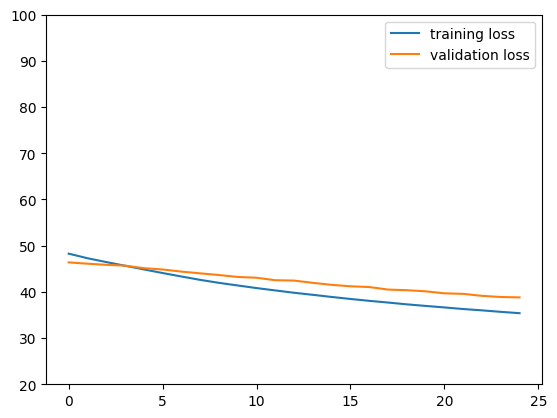

FOLD 3
--------------------------------
Epoch 1 		 Training Loss: 35.95769566361622 		 Validation Loss: 34.47441462253003
Epoch 2 		 Training Loss: 35.5900057618336 		 Validation Loss: 34.34947119367884
Epoch 3 		 Training Loss: 35.22334810482558 		 Validation Loss: 34.272545226076815
Epoch 4 		 Training Loss: 34.90434506118938 		 Validation Loss: 34.242294352105326
Epoch 5 		 Training Loss: 34.60891352417649 		 Validation Loss: 34.079992172565866
Epoch 6 		 Training Loss: 34.330746537895614 		 Validation Loss: 33.929709495382106
Epoch 7 		 Training Loss: 34.06149080748199 		 Validation Loss: 33.842451947800654
Epoch 8 		 Training Loss: 33.79739634195963 		 Validation Loss: 33.68858495671699
Epoch 9 		 Training Loss: 33.55675413275278 		 Validation Loss: 33.63496390809404
Epoch 10 		 Training Loss: 33.32327046958349 		 Validation Loss: 33.73858597938051
Epoch 11 		 Training Loss: 33.105002598095965 		 Validation Loss: 33.601508972492624
Epoch 12 		 Training Loss: 32.888013296229865 		 

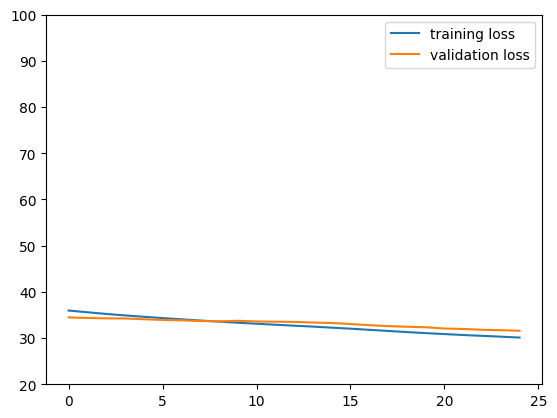

FOLD 4
--------------------------------
Epoch 1 		 Training Loss: 30.831414304753785 		 Validation Loss: 29.011073782088907
Epoch 2 		 Training Loss: 30.52776966300062 		 Validation Loss: 29.13644494401648
Epoch 3 		 Training Loss: 30.295975551810315 		 Validation Loss: 29.199360299617688
Epoch 4 		 Training Loss: 30.080996533875826 		 Validation Loss: 29.23914726744307
Epoch 5 		 Training Loss: 29.891316260060957 		 Validation Loss: 29.24738080450829
Epoch 6 		 Training Loss: 29.7079958761892 		 Validation Loss: 29.282883177412316
Epoch 7 		 Training Loss: 29.53836029832081 		 Validation Loss: 29.310843082184487
Epoch 8 		 Training Loss: 29.394867630415064 		 Validation Loss: 29.283777439847906
Epoch 9 		 Training Loss: 29.225664528467323 		 Validation Loss: 29.289989268526117
Epoch 10 		 Training Loss: 29.091049542991065 		 Validation Loss: 29.25308077386085
Epoch 11 		 Training Loss: 28.93357180523616 		 Validation Loss: 29.268382742049845
Epoch 12 		 Training Loss: 28.8171148710353

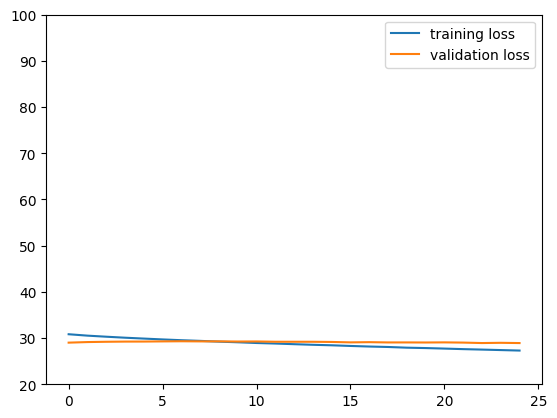

In [18]:
epochs = 25
batch = 50
simple_dataset = SimpleDataset(X_train, y_train)
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_ids, valid_ids) in enumerate(kfold.split(simple_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_loader = DataLoader(simple_dataset, batch_size=batch, sampler=train_ids)
    valid_loader = DataLoader(simple_dataset, batch_size=batch, sampler=valid_ids)

    training(epochs, model, train_loader, valid_loader, optimizer, loss_fn)

#save model
PATH = '/Users/jiabowang/Desktop/TFG/data/Models2'
torch.save(model, PATH)

In [19]:
model = torch.load('/Users/jiabowang/Desktop/TFG/data/Models2')
target = model(X_test)
# Find the Loss
loss = loss_fn(target,y_test)
print("loss testing con datos no vistos", loss)

loss testing con datos no vistos tensor(29.3979, grad_fn=<MseLossBackward0>)


In [22]:
path_keypoints = '/Users/jiabowang/Desktop/TFG/data/Blender/results_1630-16300.json'
path_truth = '/Users/jiabowang/Desktop/TFG/data/Blender/labels-1630-16300.csv'
video_input = "/Users/jiabowang/Desktop/TFG/data/1630-16300.mp4"
video_output = "/Users/jiabowang/Desktop/TFG/outputs/padel23frame.mp4"
path_model = '/Users/jiabowang/Desktop/TFG/data/Models2'
inferenciaVideoMultiploFrames(path_model, path_keypoints, path_truth, video_input, video_output, 23, 6)